In [1]:
# ! pip install -U accelerate
# ! pip install -U transformers
# ! pip install datasets peft scikit-learn
# ! pip install transformers[sentencepiece]
# !pip install matplotlib

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
#  Setting the working directory
import os
if os.getcwd() != '/home/rahpon/projects/caste':
    os.chdir('/home/rahpon/projects/caste')
    cwd = os.getcwd()
    print(cwd)
cwd = os.getcwd()
print(cwd)

/home/rahpon/projects/caste


In [5]:
import torch
import logging
import os
import json
import copy
import re
import sys
sys.path.append(os.path.join(os.getcwd(), "LLM-Adapters/peft/src"))
import argparse
import fire
import pandas as pd
import numpy as np
from datasets import load_dataset
from datasets import Dataset, DatasetDict
from transformers import (AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, TrainingArguments,Trainer, BitsAndBytesConfig,
                          AutoModelWithLMHead)
from peft import get_peft_config, get_peft_model,get_peft_model_state_dict, set_peft_model_state_dict, PeftType, PromptEncoderConfig, LoraConfig
from peft import PeftModel
from peft import (  # noqa: E402
    BottleneckConfig,
    PrefixTuningConfig,
    prepare_model_for_int8_training,
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

try:
    if torch.backends.mps.is_available():
        device = "mps"
except:  # noqa: E722
    pass


In [6]:
def classifier(model_path,output_path,lr, epochs):
    logs_dir = os.path.join(output_path,"logs")

    tokenizer = AutoTokenizer.from_pretrained(model_path, padding_side= "left") ### will have to be changed depending on model, left forgpt opt bloom
    #   if getattr(tokenizer, "pad_token_id") is None:
    #       tokenizer.pad_token_id = tokenizer.eos_token_id

    def tokenize_function(examples):
        # max_length=None => use the model max length (it's actually the default)
        outputs = tokenizer(examples["texts"], truncation=True, max_length=250)
        return outputs

    train_pd = pd.read_csv(r'DataSplit/train.csv')
    val_pd = pd.read_csv(r'DataSplit/val.csv')

    #Converting the pandas dataframe to HuggingFace DatasetDict format:
    train_ds = Dataset.from_pandas(train_pd)
    val_ds = Dataset.from_pandas(val_pd)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")
    tokenized_train = train_ds.map(tokenize_function, batched = True)
    tokenized_val = val_ds.map(tokenize_function, batched = True)
    tokenized_train = tokenized_train.rename_column("label", "labels")
    tokenized_val = tokenized_val.rename_column("label", "labels")

    
    # quantization config
    # quant_config = BitsAndBytesConfig(
    #                                 load_in_8bit=True,
    #                                 bnb_4bit_quant_type="fp4",
    #                                 bnb_4bit_use_double_quant=False,
    #                                 bnb_4bit_compute_dtype=torch.float16
    #                                 )




    
    # peft_config = PromptEncoderConfig(task_type="SEQ_CLS", num_virtual_tokens=20, encoder_hidden_size=128)
    # peft_config = LoraConfig(task_type="SEQ_CLS", num_virtual_tokens=20, encoder_hidden_size=128)
    model = AutoModelForSequenceClassification.from_pretrained(model_path,  return_dict=True)  # quantization_config=quant_config,

    
    
    config = BottleneckConfig(
                              bottleneck_size=256,
                              non_linearity="tanh",
                              adapter_dropout=0.0,
                              use_parallel_adapter=False,
                              use_adapterp=False,
                              target_modules=None,
                              scaling=1.0,
                              bias="none",
                              task_type="SEQ_CLS",
                          )

    # model.set_default_language("ta_IN")
    model = get_peft_model(model, config)
    model.print_trainable_parameters()

    def compute_metrics(eval_pred):
        preds, labels = eval_pred
        preds = np.argmax(preds, axis=1)
        accuracy = accuracy_score(labels, preds)
        precision = precision_score(labels, preds, average='weighted')
        recall = recall_score(labels, preds, average='weighted')
        f1 = f1_score(labels, preds, average='weighted')
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    training_args = TrainingArguments(
      output_dir=output_path,
      learning_rate=lr,
      per_device_train_batch_size= 8,
      per_device_eval_batch_size= 8,
      num_train_epochs=epochs,
      weight_decay=0.01,
      eval_strategy="steps",  # Evaluate at specified steps
      save_strategy="steps",
      eval_steps= 50,
      save_steps = 1500,
      logging_steps=50,
      load_best_model_at_end=True,
      logging_dir=logs_dir, #tensorboard
      # save_total_limit=5,
      #report_to = "wandb"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset = tokenized_val,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics = compute_metrics
    )
    # print("Done.....")
    train_result = trainer.train()

    # compute train results
    metrics = train_result.metrics
    max_train_samples = len(tokenized_train)
    metrics["train_samples"] = min(max_train_samples, len(tokenized_train))

    # save train results
    trainer.log_metrics("train", metrics)
    trainer.save_metrics("train", metrics)

    model.save_pretrained(training_args.output_dir)

    losses= trainer.state.log_history
    #print("trainer.state.log_history: ")
    #print(losses)
    training_loss_path = os.path.join(output_path,"training_loss.json")
    eval_loss_path = os.path.join(output_path, "eval_loss.json")
    training_losses = [entry for entry in losses if 'loss' in entry]
    eval_losses = [entry for entry in losses if 'eval_loss' in entry]
    with open(training_loss_path, 'w') as f:
        json.dump(training_losses, f, indent=2)
    with open(eval_loss_path, 'w') as f:
        json.dump(eval_losses, f, indent=2)

    # torch.cuda.empty_cache()

In [7]:
import warnings
warnings.filterwarnings("ignore")

#######################################
lr = 4e-5
EPOCHS = 5
root = os.path.join("saved_models/finetune/adapter",str(lr))
sub_dir ="bloom-560m"
output_path = os.path.join(root,sub_dir)
model_path = 'bigscience/bloom-560m'
########################################
classifier(model_path,output_path,lr, EPOCHS)



Map:   0%|          | 0/5040 [00:00<?, ? examples/s]

Map:   0%|          | 0/1260 [00:00<?, ? examples/s]

Some weights of BloomForSequenceClassification were not initialized from the model checkpoint at bigscience/bloom-560m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 25167872 || all params: 584382464 || trainable%: 4.30674661722909


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,10.758400,2.283845,0.489683,0.541804,0.489683,0.495475
100,2.008300,2.926253,0.448413,0.565429,0.448413,0.414465
150,1.303700,1.378239,0.612698,0.560823,0.612698,0.544647
200,1.227100,1.118208,0.546032,0.547221,0.546032,0.546614
250,1.121300,1.088999,0.596032,0.583547,0.596032,0.587845
300,1.309500,1.078479,0.600794,0.550935,0.600794,0.546604
350,1.079600,1.156594,0.530952,0.625187,0.530952,0.525039
400,1.142400,1.067570,0.525397,0.616429,0.525397,0.520051
450,0.958300,1.049546,0.613492,0.557401,0.613492,0.537823
500,1.166700,1.029125,0.642857,0.634767,0.642857,0.549606


***** train metrics *****
  epoch                    =        5.0
  total_flos               =  4207247GF
  train_loss               =     0.6852
  train_runtime            = 0:33:14.49
  train_samples            =       5040
  train_samples_per_second =     12.635
  train_steps_per_second   =      1.579


In [9]:
"""Predictions"""

import torch
import pandas as pd
from peft import get_peft_config, get_peft_model,get_peft_model_state_dict, set_peft_model_state_dict, PeftType, PromptEncoderConfig, LoraConfig
from peft import PeftModel, PeftConfig
from peft import (  # noqa: E402
    BottleneckConfig,
    PrefixTuningConfig,
    prepare_model_for_int8_training, BottleneckModel
)
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import confusion_matrix, classification_report

peft_model_id = output_path
config = BottleneckConfig.from_pretrained(peft_model_id)
inference_model = AutoModelForSequenceClassification.from_pretrained(config.base_model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
model = BottleneckModel(config, inference_model)

test_data_path = r"DataSplit/test.csv"
test_data = pd.read_csv(test_data_path)
test_texts = test_data['texts'].tolist()

predictions_df = test_texts

tokenized_test = tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt',max_length = 250)

batch_size = 64  # Adjust based on your available memory
predicted_labels = []  # Initialize an empty list to store the predictions
for i in tqdm(range(0, len(tokenized_test["input_ids"]), batch_size)):
    batch = {k: v[i:i+batch_size] for k, v in tokenized_test.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=-1)
    predicted_labels.extend(torch.argmax(probs, dim=-1).tolist())

predictions_df = test_data

predictions_df['predictions'] = predicted_labels

labels = test_data['labels'].tolist()

conf_matrix = confusion_matrix(predictions_df['labels'], predictions_df['predictions'])

print(conf_matrix)

class_report = classification_report(labels, predicted_labels)

print(class_report)

predictions_path = os.path.join(output_path,'predictions.csv')

predictions_df.to_csv(predictions_path)

metrics_path = os.path.join(output_path,"metrics.txt")

with open(metrics_path,'a') as f:
  f.write("PEFT")
  f.write("learning rate: ")
  f.write(str(lr))
  f.write(model_path)
  f.write("\n")
  f.write(class_report)
  f.write("Confusion Matric:\n")
  np.savetxt(f,conf_matrix,fmt = "%d")

Some weights of BloomForSequenceClassification were not initialized from the model checkpoint at bigscience/bloom-560m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 25/25 [16:24<00:00, 39.37s/it]

[[469 504]
 [320 282]]
              precision    recall  f1-score   support

           0       0.59      0.48      0.53       973
           1       0.36      0.47      0.41       602

    accuracy                           0.48      1575
   macro avg       0.48      0.48      0.47      1575
weighted avg       0.50      0.48      0.48      1575



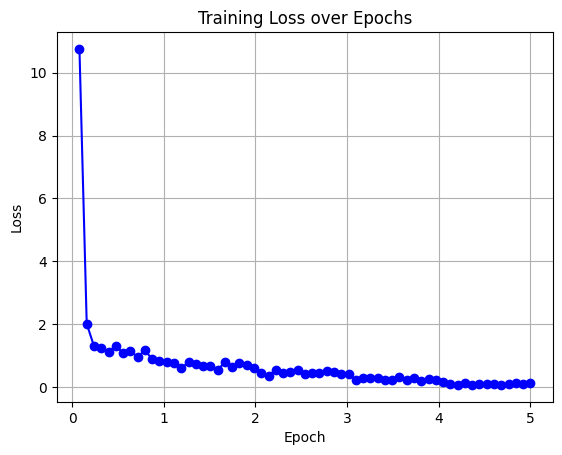

In [10]:
"""Saving Loss plots"""

import matplotlib.pyplot as plt
import json
import os
train_loss_path = os.path.join(output_path,"training_loss.json")

# Load the JSON file
with open(train_loss_path, 'r') as file:
    data = json.load(file)

# Extracting values for plotting
epochs = [entry['epoch'] for entry in data]
losses = [entry['loss'] for entry in data]

# Plotting the training losses over epochs
plt.plot(epochs, losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)


loss_plot_path = os.path.join(output_path,'training_loss_plot.png')
plt.savefig(loss_plot_path)

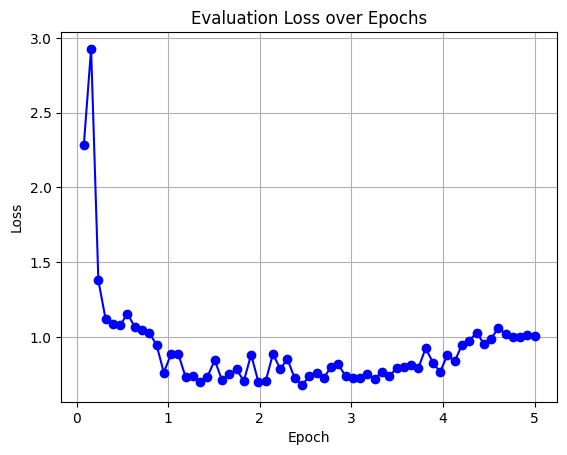

In [11]:
"""Saving Loss plots"""

import matplotlib.pyplot as plt
import json
import os
train_loss_path = os.path.join(output_path,"eval_loss.json")

# Load the JSON file
with open(train_loss_path, 'r') as file:
    data = json.load(file)

# Extracting values for plotting
epochs = [entry['epoch'] for entry in data]
losses = [entry['eval_loss'] for entry in data]

# Plotting the training losses over epochs
plt.plot(epochs, losses, marker='o', linestyle='-', color='b')
plt.title('Evaluation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)


loss_plot_path = os.path.join(output_path,'eval_loss_plot.png')
plt.savefig(loss_plot_path)